# Coupling Coefficient Calculation
We demonstrate how to calculate the coupling coefficient $\gamma$ and the magnitude of external signals to the qubit. This technique is used to measure very weak external signals, such as magnetic fields, with high precision, which is valuable in noise reduction.

1. [Ramsey Circuit](#1.-Ramsey-Circuit)
2. [Determining Coupling Coefficient](#2.-Determining-the-Coupling-Coefficient)

## Imports

In [ ]:
!pip install qiskit qiskit_aer numpy matplotlib scipy pylatexenc

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numpy import pi
import math

## 1. Ramsey Circuit

In [2]:
def ramsey_circuit(phase_shift):
    # Quantum circuit with 1 qubit and 1 classical bit
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    qc.u(0, phase_shift, 0, 0)
    qc.h(0)
    qc.measure(0, 0)
    
    # transpile the circuit to the Aer simulator
    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(qc, simulator)

    # Number of times the experiment is run
    shots = 1000

    # plot a histogram shots is the number of times the circuit is run
    job = simulator.run(compiled_circuit, shots=shots)
    result = job.result()

    counts = result.get_counts()

    # probability of the qubit being in the 1 state
    Pm = 0 if '1' not in counts else counts['1']/shots
    return Pm


### 1.1 Correlating Ramsey Circuit Output with Phase Shift

The Ramsey circuit provides a probabilistic output of either $0$ or $1$, which is influenced by the magnitude of the external signal. By repeating the experiment across various phase shifts, we can plot a sinusoidal curve where the X-axis represents the phase shift and the Y-axis represents the probability of the qubit being in the state $\ket{1}$ after the Ramsey measurement. This is known as the Ramsey Fringes.

Text(0.5, 1.0, 'Ramsey Fringes')

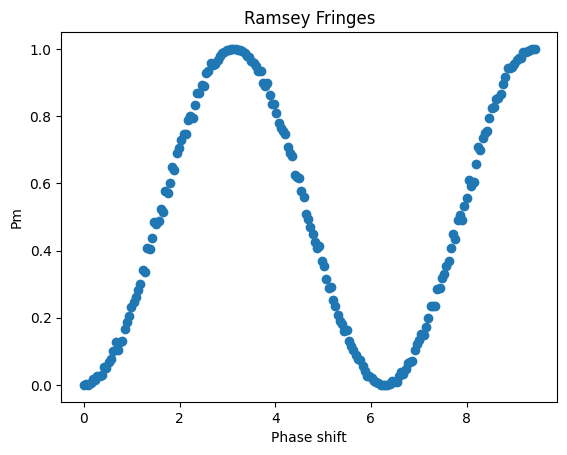

In [5]:
X_vals = np.linspace(0, 3*pi, 200)
Y_vals = [ramsey_circuit(x) for x in X_vals]
plt.plot(X_vals, Y_vals, 'o', label='Data')
plt.xlabel('Phase shift')
plt.ylabel('Pm')
plt.title('Ramsey Fringes')

### 1.2. Correlating Ramsey Circuit Output with External Signal Magnitude
As previously derived, the probability of measuring the state $\ket{1}$, denoted as $p_m$, is given by: 
$$p_m = \frac{1 - \cos(\theta)}{2}$$ 
where $\theta = \gamma \delta \Phi \tau$. <br>
Here, $\gamma$ represents the sensor's sensitivity to the external signal, $\delta\Phi$ is the change in the external signal acting on the qubit, and $\tau$ represents the exposure time, during which the qubit interacts with the external signal, resulting in an accumulated phase shift. <br>
By performing two measurements at different exposure times or signal magnitudes, we can obtain two reference points, allowing us to determine the parameter $\gamma$. A larger $\gamma$ indicates a greater phase shift magnitude in response to the external signal.

### Assumption of Small Magnitude Change in Signal

We assume that the magnitude of the change between our **bias point** (reference external signal, $p_m$) and the measured signal is minimal. To make our problem easier, we set the **bias point** to be $P_0 = 0.5$, shown in red. Around this point, the sine wave approximates a linear function (a straight line). 

$$\delta p = p_{measurement}  - p_0 = p_{measurement}  - \frac{1}{2} = \frac{1-\cos(\theta)}{2}  - \frac{1}{2} = -\frac{\cos(\theta)}{2}$$

Assuming that $\delta \Phi$ is small, the phase $\theta = \gamma \delta \Phi$ will also be small. When $\theta$ is small, we can approximate $\cos(\theta)$ using a Taylor series to simplify $\delta p$.

$$\delta p = \frac{1}{2} \gamma \delta \Phi t$$
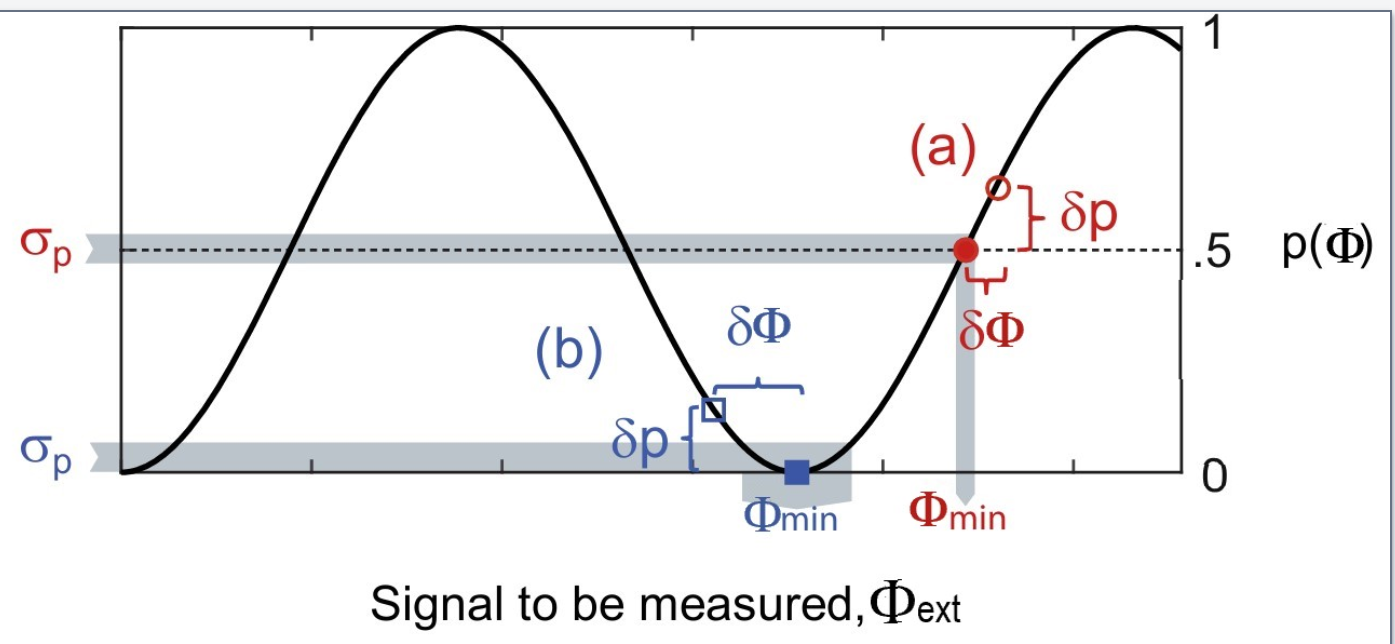

## 2. Determining the Coupling Coefficient


To determine the coupling coefficient $\gamma$, we will conduct two measurements using known reference signals: the bias point and a secondary reference. For simplicity, we will assume that the exposure time $\tau = 1$. By calculating the corresponding $p_m$ values for these reference signals, we can use the previously derived formula to compute $\gamma$.

The equation for the change in probability is:
$$\delta p = \frac{1}{2} \gamma \delta \Phi $$

To isolate $\gamma$, we rearrange the equation:
$$2 \cdot \delta p \cdot \frac{1}{\delta \Phi} = \gamma$$

In [8]:
# bias point
biasPhi = 30
biasPm = 0.5

# Magnitudes a reference signal used to determine the coupling parameter (sensor sensitivity)
Phi = 40
# The measured probabilities (pm values) corresponding to reference signal
Pm = 0.6
# calculate the deltaP values
deltaP = Pm - biasPm
deltaPhi = Phi - biasPhi
gamma = 2 * deltaP / deltaPhi

### 2.1 Calculating the magnitude of external signals using the coupling coefficent
Now that we have all the required variables, we can run the quantum sensors to take measurements and calculate the magnitude of the signals based on the phase change.

$$\delta p = \frac{1}{2} \gamma \delta \Phi $$

$$\delta p = \frac{1}{2} \gamma (\Phi_{ext} - \Phi_0) $$

$$\frac{2}{\gamma}\delta p =  (\Phi_{ext} - \Phi_0) $$

$$\frac{2}{\gamma}\delta p  +  \Phi_0=  \Phi_{ext}  $$

In [10]:
# the Pm values of the unknown signals
Pm = np.array([0.4,-0.5,0.6])
for i in range(len(Pm)):
    deltaP = biasPm-Pm[i]
    PhiExt = (2*deltaP/gamma ) + biasPhi
    print(f"PhiExt of Pm = {Pm[i]} = {PhiExt}")

PhiExt of Pm = 0.4 = 40.0
PhiExt of Pm = -0.5 = 130.0
PhiExt of Pm = 0.6 = 20.0


[0.704, 0.661, 0.639, 0.673, 0.651, 0.597, 0.629, 0.588, 0.566, 0.567, 0.561, 0.556, 0.532, 0.51, 0.476, 0.481, 0.475, 0.463, 0.465, 0.475, 0.415, 0.401, 0.378, 0.399, 0.401, 0.325, 0.349, 0.321, 0.338, 0.316]


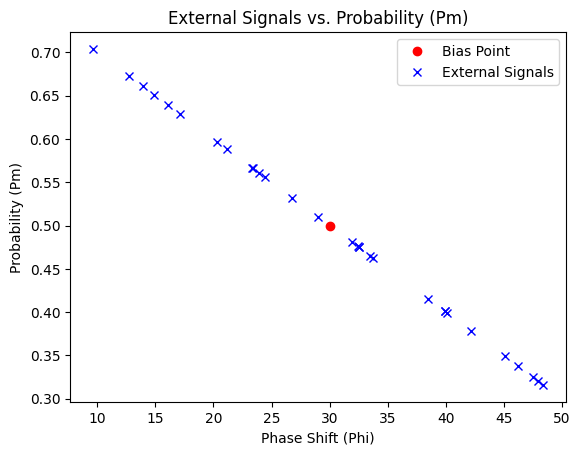

In [12]:
# Plotting the signals in proximity to the bias signal of 30. This should approximate a linear function as we are near P=0.5.
PhaseShifts = np.linspace(11*pi/8, 13*pi/8, 30)
PmsValues = [ramsey_circuit(x) for x in PhaseShifts]
print(PmsValues)

# Calculating the phase change values
PhiValues = []
for pm in PmsValues:
    deltaP = biasPm - pm
    PhiValues.append((2 * deltaP / gamma) + biasPhi)

# Plotting the bias point in red
plt.plot(biasPhi, biasPm, 'ro', label='Bias Point')

# Plotting the external signals versus the Pm values
plt.plot(PhiValues, PmsValues, 'bx', label='External Signals')
plt.xlabel('Phase Shift (Phi)')
plt.ylabel('Probability (Pm)')
plt.title('External Signals vs. Probability (Pm)')
plt.legend()